# Neural Networks learned with Metalearning vs Traditional Supervised Learning

In this notebook, 
we begin exploring the differences between neural networks and 
traditional supervised learning neural networks.  
If we are able to uncover some properties that metalearning promotes, 
then we may be able to enforce these properties in a supervised context, 
and therefore be able to achieve the same performance at a much cheaper cost-per-iteration. 


In [1]:
import numpy as np
import pickle 
import sys, os
sys.path.append("..")
from logger import Logger
from cva_model import CvaModel
from cavia_model import CaviaModel
from maml_model import MamlModel
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

## Get high performing models

In [2]:
def get_logger(pth):
    with open(pth, 'rb') as f:
        logger = pickle.load(f)
    logger.train_loss = np.asarray(logger.train_loss)
    logger.train_conf = np.asarray(logger.train_conf)

    logger.valid_loss = np.asarray(logger.valid_loss)
    logger.valid_conf = np.asarray(logger.valid_conf)

    logger.test_loss = np.asarray(logger.test_loss)
    logger.test_conf = np.asarray(logger.test_conf)

    logger.elapsed_time = np.asarray(logger.elapsed_time)
    
    return logger

In [3]:
cva_path = '../cva_sine_result_files/finalreset_10000_1000_40_0_1.pkl'
cavia_path = '../sine_result_files/final1000__10_25.pkl'
maml_path = '../maml_sine_result_files/final1000__10_25.pkl'
loggers = {
    'cva': get_logger(cva_path),
    'cavia': get_logger(cavia_path),
    'maml': get_logger(maml_path)
}
models = {
    'cva': loggers['cva'].best_valid_model,
    'cavia': loggers['cavia'].best_valid_model,
    'maml': loggers['maml'].best_valid_model
}

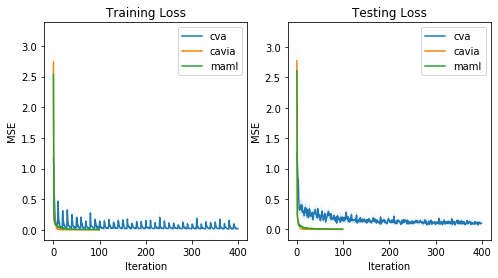

In [4]:
# plot the performance of each of these loggers as they were trained and tested
# performance vs time 
# plot each method on its own plot

plt.subplot(1, 2, 1)
for method, logger in loggers.items():
    plt.plot(np.arange(len(logger.train_loss)), logger.train_loss, label=method)
    plt.fill_between(np.arange(len(logger.train_loss)), logger.train_loss+logger.train_conf, logger.train_loss-logger.train_conf, alpha=0.2)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Training Loss')

    
plt.subplot(1, 2, 2)
for method, logger in loggers.items():
    plt.plot(np.arange(len(logger.test_loss)), logger.test_loss, label=method)
    plt.fill_between(np.arange(len(logger.test_loss)), logger.test_loss+logger.test_conf, logger.test_loss-logger.test_conf, alpha=0.2)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Testing Loss')

fig = plt.gcf()
fig.set_size_inches(8,4)
plt.show()

## Model Properties

We now compare the models based on their attributes and properties. 

### Weight norms

We start by comparing the norms of the weights of each layer, 
average of the network, the biases, and lastly the embeddings. 

In [5]:
# build dataframe of weight norm information, column=method, row=which_norm
cols = ['cva', 'cavia', 'maml']
rows = ['weights1', 'bias1', 'layer1', 'weights2', 'bias2', 'layer2', 'weights3', 'bias3', 'layer3', 'all']
norms = np.zeros((len(rows), len(cols)))

cva_allparams = []
cavia_allparams = []
maml_allparams = []
counter = 0
for r, i in enumerate(range(len(models['cva'].fc_layers))):
    cva_thislayer_w = models['cva'].fc_layers[i].weight.data.detach().cpu().numpy().flatten()
    cva_thislayer_b = models['cva'].fc_layers[i].bias.data.detach().cpu().numpy().flatten()
    cva_thislayer = np.concatenate((cva_thislayer_w, cva_thislayer_b))
    
    cavia_thislayer_w = models['cavia'].fc_layers[i].weight.data.detach().cpu().numpy().flatten()
    cavia_thislayer_b = models['cavia'].fc_layers[i].bias.data.detach().cpu().numpy().flatten()
    cavia_thislayer = np.concatenate((cavia_thislayer_w, cavia_thislayer_b))
    
    maml_thislayer_w = models['maml'].weights[i].detach().cpu().numpy().flatten()
    maml_thislayer_b = models['maml'].biases[i].detach().cpu().numpy().flatten()
    maml_thislayer = np.concatenate((maml_thislayer_w, maml_thislayer_b))
    
    norms[counter, 0] = np.linalg.norm(cva_thislayer_w)
    norms[counter, 1] = np.linalg.norm(cavia_thislayer_w)
    norms[counter, 2] = np.linalg.norm(maml_thislayer_w)
    counter += 1 
    norms[counter, 0] = np.linalg.norm(cva_thislayer_b)
    norms[counter, 1] = np.linalg.norm(cavia_thislayer_b)
    norms[counter, 2] = np.linalg.norm(maml_thislayer_b)
    counter += 1
    norms[counter, 0] = np.linalg.norm(cva_thislayer)
    norms[counter, 1] = np.linalg.norm(cavia_thislayer)
    norms[counter, 2] = np.linalg.norm(maml_thislayer)
    counter += 1
    
    cva_allparams.extend(cva_thislayer)
    cavia_allparams.extend(cavia_thislayer)
    maml_allparams.extend(maml_thislayer)

# add norm of all layers
norms[-1, 0] = np.linalg.norm(cva_allparams)
norms[-1, 1] = np.linalg.norm(cavia_allparams)
norms[-1, 2] = np.linalg.norm(maml_allparams)

# put all info and dataframe and print
norms_df = pd.DataFrame(norms, rows, cols)
print("Norms of each network and layer")
print(tabulate(norms_df, headers='keys', tablefmt='psql'))

Norms of each network and layer
+----------+----------+-----------+-----------+
|          |      cva |     cavia |      maml |
|----------+----------+-----------+-----------|
| weights1 | 37.1155  |  3.44962  | 22.1149   |
| bias1    |  4.80267 |  5.66577  |  3.43218  |
| layer1   | 37.4249  |  6.63331  | 22.3797   |
| weights2 | 26.4012  | 14.2705   | 18.0822   |
| bias2    |  3.63674 |  1.96621  |  2.83849  |
| layer2   | 26.6505  | 14.4053   | 18.3037   |
| weights3 |  1.42542 |  3.00606  |  3.83113  |
| bias3    |  0.75132 |  0.145331 |  0.100933 |
| layer3   |  1.61131 |  3.00957  |  3.83246  |
| all      | 45.9725  | 16.1422   | 29.1644   |
+----------+----------+-----------+-----------+


In [6]:
# build dataframe of weight norm information, column=method, row=which_norm
cols = ['cva', 'cavia', 'maml']
rows = [
    'weights1_mean', 
    'weights1_median', 
    'weights1_min', 
    'weights1_max', 
    'weights1_std', 
    'weights2_mean', 
    'weights2_median', 
    'weights2_min', 
    'weights2_max', 
    'weights2_std', 
    'weights3_mean', 
    'weights3_median', 
    'weights3_min', 
    'weights3_max', 
    'weights3_std', 
    'all_mean',
    'all_median',
    'all_max',
    'all_min',
    'all_std'
]
norms = np.zeros((len(rows), len(cols)))

cva_allparams = []
cavia_allparams = []
maml_allparams = []
counter = 0
for r, i in enumerate(range(len(models['cva'].fc_layers))):
    cva_thislayer_w = models['cva'].fc_layers[i].weight.data.detach().cpu().numpy().flatten()

    cavia_thislayer_w = models['cavia'].fc_layers[i].weight.data.detach().cpu().numpy().flatten()
    
    maml_thislayer_w = models['maml'].weights[i].detach().cpu().numpy().flatten()
    
    norms[counter, 0] = np.mean(cva_thislayer_w)
    norms[counter, 1] = np.mean(cavia_thislayer_w)
    norms[counter, 2] = np.mean(maml_thislayer_w)
    counter += 1 
    norms[counter, 0] = np.median(cva_thislayer_w)
    norms[counter, 1] = np.median(cavia_thislayer_w)
    norms[counter, 2] = np.median(maml_thislayer_w)
    counter += 1 
    norms[counter, 0] = np.min(cva_thislayer_w)
    norms[counter, 1] = np.min(cavia_thislayer_w)
    norms[counter, 2] = np.min(maml_thislayer_w)
    counter += 1 
    norms[counter, 0] = np.max(cva_thislayer_w)
    norms[counter, 1] = np.max(cavia_thislayer_w)
    norms[counter, 2] = np.max(maml_thislayer_w)
    counter += 1 
    norms[counter, 0] = np.std(cva_thislayer_w)
    norms[counter, 1] = np.std(cavia_thislayer_w)
    norms[counter, 2] = np.std(maml_thislayer_w)
    counter += 1 
    
    cva_allparams.extend(cva_thislayer_w)
    cavia_allparams.extend(cavia_thislayer_w)
    maml_allparams.extend(maml_thislayer_w)

# add norm of all layers
norms[-5, 0] = np.mean(cva_allparams)
norms[-5, 1] = np.mean(cavia_allparams)
norms[-5, 2] = np.mean(maml_allparams)
norms[-4, 0] = np.median(cva_allparams)
norms[-4, 1] = np.median(cavia_allparams)
norms[-4, 2] = np.median(maml_allparams)
norms[-3, 0] = np.max(cva_allparams)
norms[-3, 1] = np.max(cavia_allparams)
norms[-3, 2] = np.max(maml_allparams)
norms[-2, 0] = np.min(cva_allparams)
norms[-2, 1] = np.min(cavia_allparams)
norms[-2, 2] = np.min(maml_allparams)
norms[-1, 0] = np.std(cva_allparams)
norms[-1, 1] = np.std(cavia_allparams)
norms[-1, 2] = np.std(maml_allparams)

# put all info and dataframe and print
norms_df = pd.DataFrame(norms, rows, cols)
print("Statistics of each network and layer weights")
print(tabulate(norms_df, headers='keys', tablefmt='psql'))

Statistics of each network and layer weights
+-----------------+-------------+-------------+-------------+
|                 |         cva |       cavia |        maml |
|-----------------+-------------+-------------+-------------|
| weights1_mean   | -0.079036   |  0.036589   | -0.0224376  |
| weights1_median | -0.0595048  |  0.0126002  | -0.00993508 |
| weights1_min    | -6.58468    | -0.659053   | -4.57623    |
| weights1_max    |  6.61589    |  0.804998   |  7.25858    |
| weights1_std    |  2.39449    |  0.219645   |  1.42734    |
| weights2_mean   | -0.106973   | -0.0558731  | -0.0333053  |
| weights2_median | -0.0384459  | -0.00695439 | -0.00226847 |
| weights2_min    | -4.84868    | -2.67931    | -3.45658    |
| weights2_max    |  2.59726    |  2.15032    |  2.17051    |
| weights2_std    |  0.651303   |  0.35236    |  0.450828   |
| weights3_mean   | -0.0242492  | -0.0831294  |  0.00191195 |
| weights3_median |  0.00195201 | -0.269163   |  0.188875   |
| weights3_min    | -0.53

In [9]:
# build dataframe of weight norm information, column=method, row=which_norm
cols = ['cva', 'cavia', 'maml']
rows = [
    'bias1_mean', 
    'bias1_median', 
    'bias1_min', 
    'bias1_max', 
    'bias1_std', 
    'bias2_mean', 
    'bias2_median', 
    'bias2_min', 
    'bias2_max', 
    'bias2_std', 
    'bias3_mean', 
    'bias3_median', 
    'bias3_min', 
    'bias3_max', 
    'bias3_std', 
    'all_mean',
    'all_median',
    'all_max',
    'all_min',
    'all_std'
]
norms = np.zeros((len(rows), len(cols)))

cva_allparams = []
cavia_allparams = []
maml_allparams = []
counter = 0
for r, i in enumerate(range(len(models['cva'].fc_layers))):
    cva_thislayer_w = models['cva'].fc_layers[i].bias.data.detach().cpu().numpy().flatten()

    cavia_thislayer_w = models['cavia'].fc_layers[i].bias.data.detach().cpu().numpy().flatten()
    
    maml_thislayer_w = models['maml'].biases[i].detach().cpu().numpy().flatten()
    
    norms[counter, 0] = np.mean(cva_thislayer_w)
    norms[counter, 1] = np.mean(cavia_thislayer_w)
    norms[counter, 2] = np.mean(maml_thislayer_w)
    counter += 1 
    norms[counter, 0] = np.median(cva_thislayer_w)
    norms[counter, 1] = np.median(cavia_thislayer_w)
    norms[counter, 2] = np.median(maml_thislayer_w)
    counter += 1 
    norms[counter, 0] = np.min(cva_thislayer_w)
    norms[counter, 1] = np.min(cavia_thislayer_w)
    norms[counter, 2] = np.min(maml_thislayer_w)
    counter += 1 
    norms[counter, 0] = np.max(cva_thislayer_w)
    norms[counter, 1] = np.max(cavia_thislayer_w)
    norms[counter, 2] = np.max(maml_thislayer_w)
    counter += 1 
    norms[counter, 0] = np.std(cva_thislayer_w)
    norms[counter, 1] = np.std(cavia_thislayer_w)
    norms[counter, 2] = np.std(maml_thislayer_w)
    counter += 1 
    
    cva_allparams.extend(cva_thislayer_w)
    cavia_allparams.extend(cavia_thislayer_w)
    maml_allparams.extend(maml_thislayer_w)

# add norm of all layers
norms[-5, 0] = np.mean(cva_allparams)
norms[-5, 1] = np.mean(cavia_allparams)
norms[-5, 2] = np.mean(maml_allparams)
norms[-4, 0] = np.median(cva_allparams)
norms[-4, 1] = np.median(cavia_allparams)
norms[-4, 2] = np.median(maml_allparams)
norms[-3, 0] = np.max(cva_allparams)
norms[-3, 1] = np.max(cavia_allparams)
norms[-3, 2] = np.max(maml_allparams)
norms[-2, 0] = np.min(cva_allparams)
norms[-2, 1] = np.min(cavia_allparams)
norms[-2, 2] = np.min(maml_allparams)
norms[-1, 0] = np.std(cva_allparams)
norms[-1, 1] = np.std(cavia_allparams)
norms[-1, 2] = np.std(maml_allparams)

# put all info and dataframe and print
norms_df = pd.DataFrame(norms, rows, cols)
print("Statistics of each network and layer biases")
print(tabulate(norms_df, headers='keys', tablefmt='psql'))

Statistics of each network and layer biases
+--------------+------------+-------------+-------------+
|              |        cva |       cavia |        maml |
|--------------+------------+-------------+-------------|
| bias1_mean   | -0.294991  | -0.098702   | -0.184866   |
| bias1_median | -0.328775  |  0.0279047  |  0.038977   |
| bias1_min    | -1.88092   | -1.49757    | -1.51176    |
| bias1_max    |  1.5205    |  1.88272    |  0.481013   |
| bias1_std    |  0.69973   |  0.890383   |  0.510217   |
| bias2_mean   | -0.0330652 |  0.00941053 |  0.00289167 |
| bias2_median |  0.0415063 |  0.032209   |  0.128024   |
| bias2_min    | -2.41476   | -1.01354    | -1.25452    |
| bias2_max    |  1.06393   |  0.476575   |  0.820321   |
| bias2_std    |  0.574067  |  0.310743   |  0.448796   |
| bias3_mean   |  0.75132   |  0.145331   | -0.100933   |
| bias3_median |  0.75132   |  0.145331   | -0.100933   |
| bias3_min    |  0.75132   |  0.145331   | -0.100933   |
| bias3_max    |  0.75132   

In [8]:
# build dataframe of weight norm information, column=method, row=which_norm
cols = ['cva', 'cavia', 'maml']
rows = [
    'layer1_mean', 
    'layer1_median', 
    'layer1_min', 
    'layer1_max', 
    'layer1_std', 
    'layer2_mean', 
    'layer2_median', 
    'layer2_min', 
    'layer2_max', 
    'layer2_std', 
    'layer3_mean', 
    'layer3_median', 
    'layer3_min', 
    'layer3_max', 
    'layer3_std', 
    'all_mean',
    'all_median',
    'all_max',
    'all_min',
    'all_std'
]
norms = np.zeros((len(rows), len(cols)))

cva_allparams = []
cavia_allparams = []
maml_allparams = []
counter = 0
for r, i in enumerate(range(len(models['cva'].fc_layers))):
    cva_thislayer_w = models['cva'].fc_layers[i].weight.data.detach().cpu().numpy().flatten()
    cva_thislayer_b = models['cva'].fc_layers[i].bias.data.detach().cpu().numpy().flatten()
    cva_thislayer = np.concatenate((cva_thislayer_w, cva_thislayer_b))
    
    cavia_thislayer_w = models['cavia'].fc_layers[i].weight.data.detach().cpu().numpy().flatten()
    cavia_thislayer_b = models['cavia'].fc_layers[i].bias.data.detach().cpu().numpy().flatten()
    cavia_thislayer = np.concatenate((cavia_thislayer_w, cavia_thislayer_b))
    
    maml_thislayer_w = models['maml'].weights[i].detach().cpu().numpy().flatten()
    maml_thislayer_b = models['maml'].biases[i].detach().cpu().numpy().flatten()
    maml_thislayer = np.concatenate((maml_thislayer_w, maml_thislayer_b))
    
    norms[counter, 0] = np.mean(cva_thislayer)
    norms[counter, 1] = np.mean(cavia_thislayer)
    norms[counter, 2] = np.mean(maml_thislayer)
    counter += 1 
    norms[counter, 0] = np.median(cva_thislayer)
    norms[counter, 1] = np.median(cavia_thislayer)
    norms[counter, 2] = np.median(maml_thislayer)
    counter += 1 
    norms[counter, 0] = np.min(cva_thislayer)
    norms[counter, 1] = np.min(cavia_thislayer)
    norms[counter, 2] = np.min(maml_thislayer)
    counter += 1 
    norms[counter, 0] = np.max(cva_thislayer)
    norms[counter, 1] = np.max(cavia_thislayer)
    norms[counter, 2] = np.max(maml_thislayer)
    counter += 1 
    norms[counter, 0] = np.std(cva_thislayer)
    norms[counter, 1] = np.std(cavia_thislayer)
    norms[counter, 2] = np.std(maml_thislayer)
    counter += 1 
    
    cva_allparams.extend(cva_thislayer)
    cavia_allparams.extend(cavia_thislayer)
    maml_allparams.extend(maml_thislayer)

# add norm of all layers
norms[-5, 0] = np.mean(cva_allparams)
norms[-5, 1] = np.mean(cavia_allparams)
norms[-5, 2] = np.mean(maml_allparams)
norms[-4, 0] = np.median(cva_allparams)
norms[-4, 1] = np.median(cavia_allparams)
norms[-4, 2] = np.median(maml_allparams)
norms[-3, 0] = np.max(cva_allparams)
norms[-3, 1] = np.max(cavia_allparams)
norms[-3, 2] = np.max(maml_allparams)
norms[-2, 0] = np.min(cva_allparams)
norms[-2, 1] = np.min(cavia_allparams)
norms[-2, 2] = np.min(maml_allparams)
norms[-1, 0] = np.std(cva_allparams)
norms[-1, 1] = np.std(cavia_allparams)
norms[-1, 2] = np.std(maml_allparams)

# put all info and dataframe and print
norms_df = pd.DataFrame(norms, rows, cols)
print("Statistics of each network and layer")
print(tabulate(norms_df, headers='keys', tablefmt='psql'))

Statistics of each network and layer
+---------------+-------------+-------------+--------------+
|               |         cva |       cavia |         maml |
|---------------+-------------+-------------+--------------|
| layer1_mean   | -0.109887   |  0.0172617  | -0.0456417   |
| layer1_median | -0.132766   |  0.0126002  | -0.00821249  |
| layer1_min    | -6.58468    | -1.49757    | -4.57623     |
| layer1_max    |  6.61589    |  1.88272    |  7.25858     |
| layer1_std    |  2.23387    |  0.39604    |  1.33666     |
| layer2_mean   | -0.10517    | -0.0542809  | -0.0324224   |
| layer2_median | -0.0378517  | -0.00597292 | -0.000579109 |
| layer2_min    | -4.84868    | -2.67931    | -3.45658     |
| layer2_max    |  2.59726    |  2.15032    |  2.17051     |
| layer2_std    |  0.649628   |  0.351548   |  0.450813    |
| layer3_mean   | -0.00533287 | -0.0775572  | -0.000596457 |
| layer3_median |  0.0137761  | -0.230385   |  0.094707    |
| layer3_min    | -0.535879   | -0.80633    | -0

## Analysis of results so far

From the above tables, there is no obvious difference between the network statistics of CVA, CAVIA, and MAML.
It seems that CVA has a bit higher standard deviation in its weights compared to CAVIA and MAML, 
but these results are weak. 

# Comparison of pre and post fine-tuned networks

Now we move to comparing CAVIA and MAML in their pre and post fine-tuned states.  
Because CVA doesn't really have a pre and post fine-tuned state, 
we will just add the same statistics as are included above for a final compairison. 